# CNN Architecture - Comprehensive Guide for Exam Preparation

This notebook provides a complete understanding of Convolutional Neural Networks (CNNs) covering:
- Mathematical foundations of convolution
- CNN building blocks and components
- Popular architectures (LeNet, AlexNet, VGG, ResNet)
- Implementation from scratch and with PyTorch
- Practical applications and optimization techniques
- Visualization and interpretation methods

**Key Exam Topics Covered:**
- Convolution vs Correlation
- Padding, Stride, and Dilation
- Pooling operations
- Feature maps and receptive fields
- Backpropagation in CNNs
- Architecture design principles

## 1. Import Required Libraries and Setup

In [1]:
# Essential libraries for CNN implementation and analysis
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST

# Numerical computing and visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.signal import correlate2d

# Optional imports
try:
    import cv2
    print("✅ OpenCV imported successfully")
except ImportError:
    print("⚠️ OpenCV not available, some features may be limited")
    cv2 = None

try:
    from PIL import Image
    print("✅ PIL imported successfully")
except ImportError:
    print("⚠️ PIL not available, using matplotlib for image handling")
    Image = None

# Utilities
import time
import os
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Matplotlib settings for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

⚠️ OpenCV not available, some features may be limited
✅ PIL imported successfully
Using device: cuda
✅ All libraries imported successfully!
PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121


In [3]:
# Helper functions for visualization and analysis
def plot_image_with_title(img, title, figsize=(6, 6)):
    """Plot a single image with title."""
    plt.figure(figsize=figsize)
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_multiple_images(images, titles, rows=1, cols=None, figsize=(15, 5)):
    """Plot multiple images in a grid."""
    if cols is None:
        cols = len(images)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows * cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    for i, (img, title) in enumerate(zip(images, titles)):
        if len(img.shape) == 3:
            axes[i].imshow(img)
        else:
            axes[i].imshow(img, cmap='gray')
        axes[i].set_title(title)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_feature_maps(feature_maps, title="Feature Maps", max_maps=16):
    """Visualize feature maps from a conv layer."""
    n_maps = min(feature_maps.shape[0], max_maps)
    cols = 4
    rows = (n_maps + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten() if rows > 1 else [axes] if rows == 1 else axes
    
    for i in range(n_maps):
        axes[i].imshow(feature_maps[i], cmap='viridis')
        axes[i].set_title(f'Map {i+1}')
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(n_maps, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

print("✅ Helper functions defined successfully!")

✅ Helper functions defined successfully!


## 2. Understanding Convolution Operation

### Mathematical Foundation
The convolution operation is the core of CNNs. For a 2D discrete convolution:

**Convolution**: $(f * g)[m,n] = \sum_i \sum_j f[i,j] \cdot g[m-i, n-j]$

**Cross-correlation**: $(f \star g)[m,n] = \sum_i \sum_j f[i,j] \cdot g[m+i, n+j]$

**Key Differences:**
- **Convolution**: Flips the kernel before sliding
- **Cross-correlation**: Slides kernel as-is (what most deep learning frameworks call "convolution")

### Important Concepts for Exam:
1. **Padding**: Adding zeros around input to control output size
2. **Stride**: Step size when sliding the kernel
3. **Dilation**: Spacing between kernel elements
4. **Output size formula**: `[(W - K + 2P) / S] + 1`
   - W: input width, K: kernel size, P: padding, S: stride

In [4]:
# Implementing Convolution from Scratch
def convolution_2d(image, kernel, padding=0, stride=1):
    """
    Perform 2D convolution operation.
    
    Args:
        image: Input image (H x W)
        kernel: Convolution kernel (K x K)
        padding: Padding size
        stride: Stride size
    
    Returns:
        Convolved output
    """
    # Add padding
    if padding > 0:
        image = np.pad(image, padding, mode='constant', constant_values=0)
    
    # Get dimensions
    img_h, img_w = image.shape
    kernel_h, kernel_w = kernel.shape
    
    # Calculate output dimensions
    out_h = (img_h - kernel_h) // stride + 1
    out_w = (img_w - kernel_w) // stride + 1
    
    # Initialize output
    output = np.zeros((out_h, out_w))
    
    # Perform convolution
    for i in range(0, out_h):
        for j in range(0, out_w):
            # Extract region
            region = image[i*stride:i*stride+kernel_h, j*stride:j*stride+kernel_w]
            # Compute convolution (flip kernel for true convolution)
            output[i, j] = np.sum(region * np.flip(kernel))
    
    return output

def cross_correlation_2d(image, kernel, padding=0, stride=1):
    """
    Perform 2D cross-correlation (what DL frameworks call convolution).
    """
    # Add padding
    if padding > 0:
        image = np.pad(image, padding, mode='constant', constant_values=0)
    
    # Get dimensions
    img_h, img_w = image.shape
    kernel_h, kernel_w = kernel.shape
    
    # Calculate output dimensions
    out_h = (img_h - kernel_h) // stride + 1
    out_w = (img_w - kernel_w) // stride + 1
    
    # Initialize output
    output = np.zeros((out_h, out_w))
    
    # Perform cross-correlation
    for i in range(0, out_h):
        for j in range(0, out_w):
            # Extract region
            region = image[i*stride:i*stride+kernel_h, j*stride:j*stride+kernel_w]
            # Compute cross-correlation (no flipping)
            output[i, j] = np.sum(region * kernel)
    
    return output

# Test with example
# Create a simple image
test_image = np.array([
    [1, 2, 3, 4, 5],
    [6, 7, 8, 9, 10],
    [11, 12, 13, 14, 15],
    [16, 17, 18, 19, 20],
    [21, 22, 23, 24, 25]
])

# Edge detection kernel
edge_kernel = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

# Apply convolution and cross-correlation
conv_result = convolution_2d(test_image, edge_kernel)
corr_result = cross_correlation_2d(test_image, edge_kernel)

print("Original Image:")
print(test_image)
print("\nEdge Detection Kernel:")
print(edge_kernel)
print("\nConvolution Result:")
print(conv_result)
print("\nCross-correlation Result:")
print(corr_result)
print("\nAre results the same?", np.allclose(conv_result, corr_result))

Original Image:
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]
 [21 22 23 24 25]]

Edge Detection Kernel:
[[-1 -1 -1]
 [-1  8 -1]
 [-1 -1 -1]]

Convolution Result:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Cross-correlation Result:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Are results the same? True


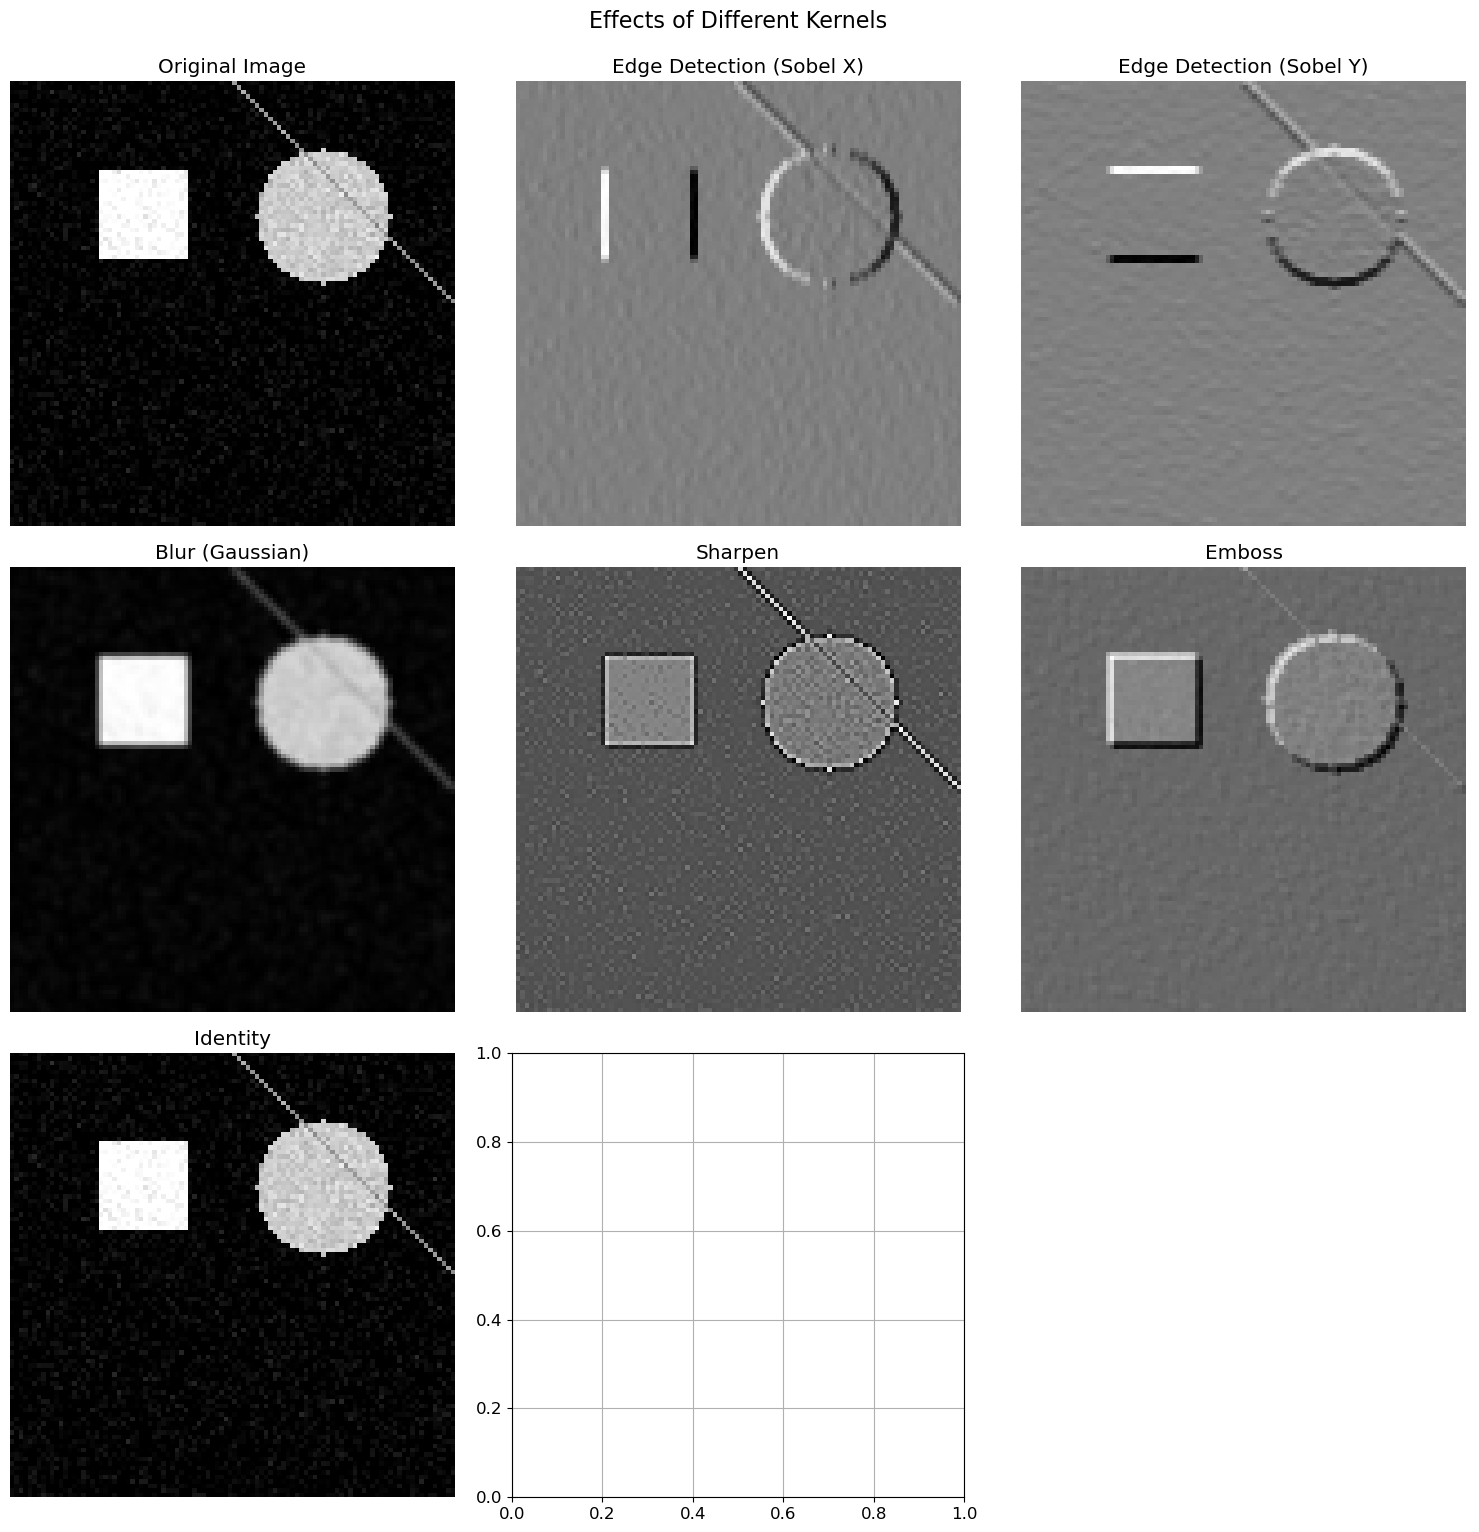

Kernel Details:

Edge Detection (Sobel X):
[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
Sum: 0.00

Edge Detection (Sobel Y):
[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]
Sum: 0.00

Blur (Gaussian):
[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]
Sum: 1.00

Sharpen:
[[ 0 -1  0]
 [-1  5 -1]
 [ 0 -1  0]]
Sum: 1.00

Emboss:
[[-2 -1  0]
 [-1  1  1]
 [ 0  1  2]]
Sum: 1.00

Identity:
[[0 0 0]
 [0 1 0]
 [0 0 0]]
Sum: 1.00


In [5]:
# Common Kernels and Their Effects
def create_sample_image():
    """Create a sample image with various features."""
    img = np.zeros((100, 100))
    
    # Add a square
    img[20:40, 20:40] = 1
    
    # Add a circle
    center = (70, 30)
    radius = 15
    y, x = np.ogrid[:100, :100]
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2
    img[mask] = 0.8
    
    # Add diagonal line
    for i in range(50):
        if i < 100 and 50+i < 100:
            img[i, 50+i] = 0.6
    
    # Add noise
    noise = np.random.normal(0, 0.05, img.shape)
    img = np.clip(img + noise, 0, 1)
    
    return img

# Define various kernels
kernels = {
    'Edge Detection (Sobel X)': np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
    'Edge Detection (Sobel Y)': np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
    'Blur (Gaussian)': np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16,
    'Sharpen': np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]),
    'Emboss': np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]]),
    'Identity': np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
}

# Create sample image
sample_img = create_sample_image()

# Apply different kernels
results = {}
for name, kernel in kernels.items():
    result = cross_correlation_2d(sample_img, kernel, padding=1)
    results[name] = result

# Visualize results
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Plot original
axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot kernel effects
for i, (name, result) in enumerate(results.items(), 1):
    axes[i].imshow(result, cmap='gray')
    axes[i].set_title(f'{name}')
    axes[i].axis('off')

# Hide last subplot
axes[-1].axis('off')

plt.tight_layout()
plt.suptitle('Effects of Different Kernels', fontsize=16, y=1.02)
plt.show()

# Print kernel information
print("Kernel Details:")
for name, kernel in kernels.items():
    print(f"\n{name}:")
    print(kernel)
    print(f"Sum: {kernel.sum():.2f}")

## 3. Building Blocks of CNNs

### Core Components:

1. **Convolutional Layer**
   - Applies multiple filters to input
   - Creates feature maps
   - Preserves spatial relationships
   - Reduces parameters through weight sharing

2. **Pooling Layer**
   - Reduces spatial dimensions
   - Provides translation invariance
   - Types: Max, Average, Global Average
   - No learnable parameters

3. **Activation Functions**
   - Introduces non-linearity
   - Common: ReLU, Leaky ReLU, ELU
   - Applied element-wise

4. **Fully Connected (Dense) Layer**
   - Connects every input to every output
   - Usually at the end for classification
   - Flattens spatial information

### Key Concepts:

- **Receptive Field**: Region of input that affects a particular output
- **Feature Maps**: Output of convolution operations
- **Depth**: Number of channels/filters
- **Spatial Hierarchy**: Low-level → High-level features

Testing CNN Building Blocks
Input shape: (32, 32)
After Conv Layer: (8, 32, 32)
After Max Pooling: (8, 16, 16)
Receptive field size after conv: 3x3


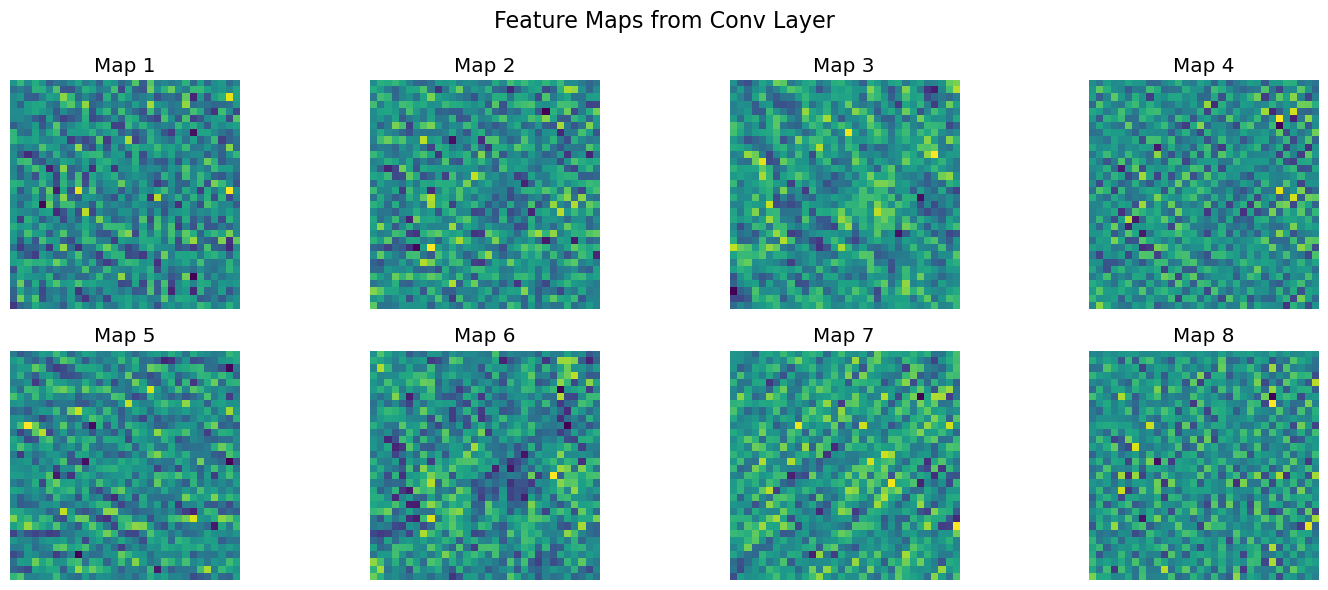

In [6]:
# Implementing Basic CNN Building Blocks

class ConvolutionalLayer:
    """Simple convolutional layer implementation."""
    
    def __init__(self, num_filters, filter_size, stride=1, padding=0):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.stride = stride
        self.padding = padding
        
        # Initialize filters with small random values
        self.filters = np.random.randn(num_filters, filter_size, filter_size) * 0.1
        self.bias = np.zeros(num_filters)
    
    def forward(self, input_image):
        """Forward pass through convolutional layer."""
        if len(input_image.shape) == 2:
            input_image = input_image[np.newaxis, :, :]  # Add channel dimension
        
        batch_size, channels, height, width = input_image.shape[0], 1, input_image.shape[-2], input_image.shape[-1]
        
        # Calculate output dimensions
        out_height = (height + 2 * self.padding - self.filter_size) // self.stride + 1
        out_width = (width + 2 * self.padding - self.filter_size) // self.stride + 1
        
        # Initialize output
        output = np.zeros((self.num_filters, out_height, out_width))
        
        # Apply each filter
        for f in range(self.num_filters):
            # Convolve filter with input
            conv_result = cross_correlation_2d(input_image.squeeze(), self.filters[f], 
                                             padding=self.padding, stride=self.stride)
            output[f] = conv_result + self.bias[f]
        
        return output
    
    def get_receptive_field_size(self, input_rf_size=1):
        """Calculate receptive field size."""
        return (input_rf_size - 1) * self.stride + self.filter_size

class PoolingLayer:
    """Pooling layer implementation."""
    
    def __init__(self, pool_size=2, stride=2, mode='max'):
        self.pool_size = pool_size
        self.stride = stride
        self.mode = mode
    
    def forward(self, feature_maps):
        """Forward pass through pooling layer."""
        if len(feature_maps.shape) == 2:
            feature_maps = feature_maps[np.newaxis, :, :]
        
        num_channels, height, width = feature_maps.shape
        
        # Calculate output dimensions
        out_height = (height - self.pool_size) // self.stride + 1
        out_width = (width - self.pool_size) // self.stride + 1
        
        # Initialize output
        output = np.zeros((num_channels, out_height, out_width))
        
        # Apply pooling to each channel
        for c in range(num_channels):
            for i in range(out_height):
                for j in range(out_width):
                    # Extract pool region
                    pool_region = feature_maps[c, 
                                              i*self.stride:i*self.stride+self.pool_size,
                                              j*self.stride:j*self.stride+self.pool_size]
                    
                    # Apply pooling operation
                    if self.mode == 'max':
                        output[c, i, j] = np.max(pool_region)
                    elif self.mode == 'avg':
                        output[c, i, j] = np.mean(pool_region)
        
        return output

# Test the building blocks
print("Testing CNN Building Blocks")
print("=" * 40)

# Create test input
test_input = np.random.randn(32, 32)
print(f"Input shape: {test_input.shape}")

# Test convolutional layer
conv_layer = ConvolutionalLayer(num_filters=8, filter_size=3, stride=1, padding=1)
conv_output = conv_layer.forward(test_input)
print(f"After Conv Layer: {conv_output.shape}")

# Test pooling layer
pool_layer = PoolingLayer(pool_size=2, stride=2, mode='max')
pool_output = pool_layer.forward(conv_output)
print(f"After Max Pooling: {pool_output.shape}")

# Calculate receptive field
rf_size = conv_layer.get_receptive_field_size()
print(f"Receptive field size after conv: {rf_size}x{rf_size}")

# Visualize first few feature maps
visualize_feature_maps(conv_output[:8], "Feature Maps from Conv Layer", max_maps=8)

## 4. CNN Layer Types and Components

### Layer Types:

1. **Conv1D**: For sequential data (text, time series)
2. **Conv2D**: For images (most common)
3. **Conv3D**: For video, 3D medical images
4. **ConvTranspose**: For upsampling (deconvolution)

### Pooling Types:

1. **MaxPool**: Takes maximum value in region
2. **AvgPool**: Takes average value in region
3. **GlobalAvgPool**: Averages entire feature map
4. **AdaptivePool**: Pools to specific output size

### Output Size Calculations:

**Convolution**: `Output = [(Input + 2×Padding - Kernel) / Stride] + 1`

**Pooling**: `Output = [(Input - Kernel) / Stride] + 1`

### Padding Strategies:

- **Valid**: No padding (output smaller than input)
- **Same**: Padding to keep same size
- **Full**: Maximum padding

CNN Layer Types Demonstration
1D Input shape: torch.Size([1, 16, 100])
2D Input shape: torch.Size([1, 3, 64, 64])
3D Input shape: torch.Size([1, 1, 16, 32, 32])

1D Conv Output: torch.Size([1, 32, 100])
2D Conv Output: torch.Size([1, 64, 64, 64])
3D Conv Output: torch.Size([1, 8, 16, 32, 32])

Pooling Operations
MaxPool Output: torch.Size([1, 64, 32, 32])
AvgPool Output: torch.Size([1, 64, 32, 32])
Global AvgPool Output: torch.Size([1, 64, 1, 1])
Adaptive Pool Output: torch.Size([1, 64, 8, 8])

Output Size Calculations
Input: 64x64
Kernel: 3, Stride: 1, Padding: 1
Calculated output size: 64x64
Actual output size: 64x64

Padding Strategies
Original input shape: torch.Size([1, 1, 5, 5])
Valid padding output: torch.Size([1, 1, 3, 3])
Same padding output: torch.Size([1, 1, 5, 5])


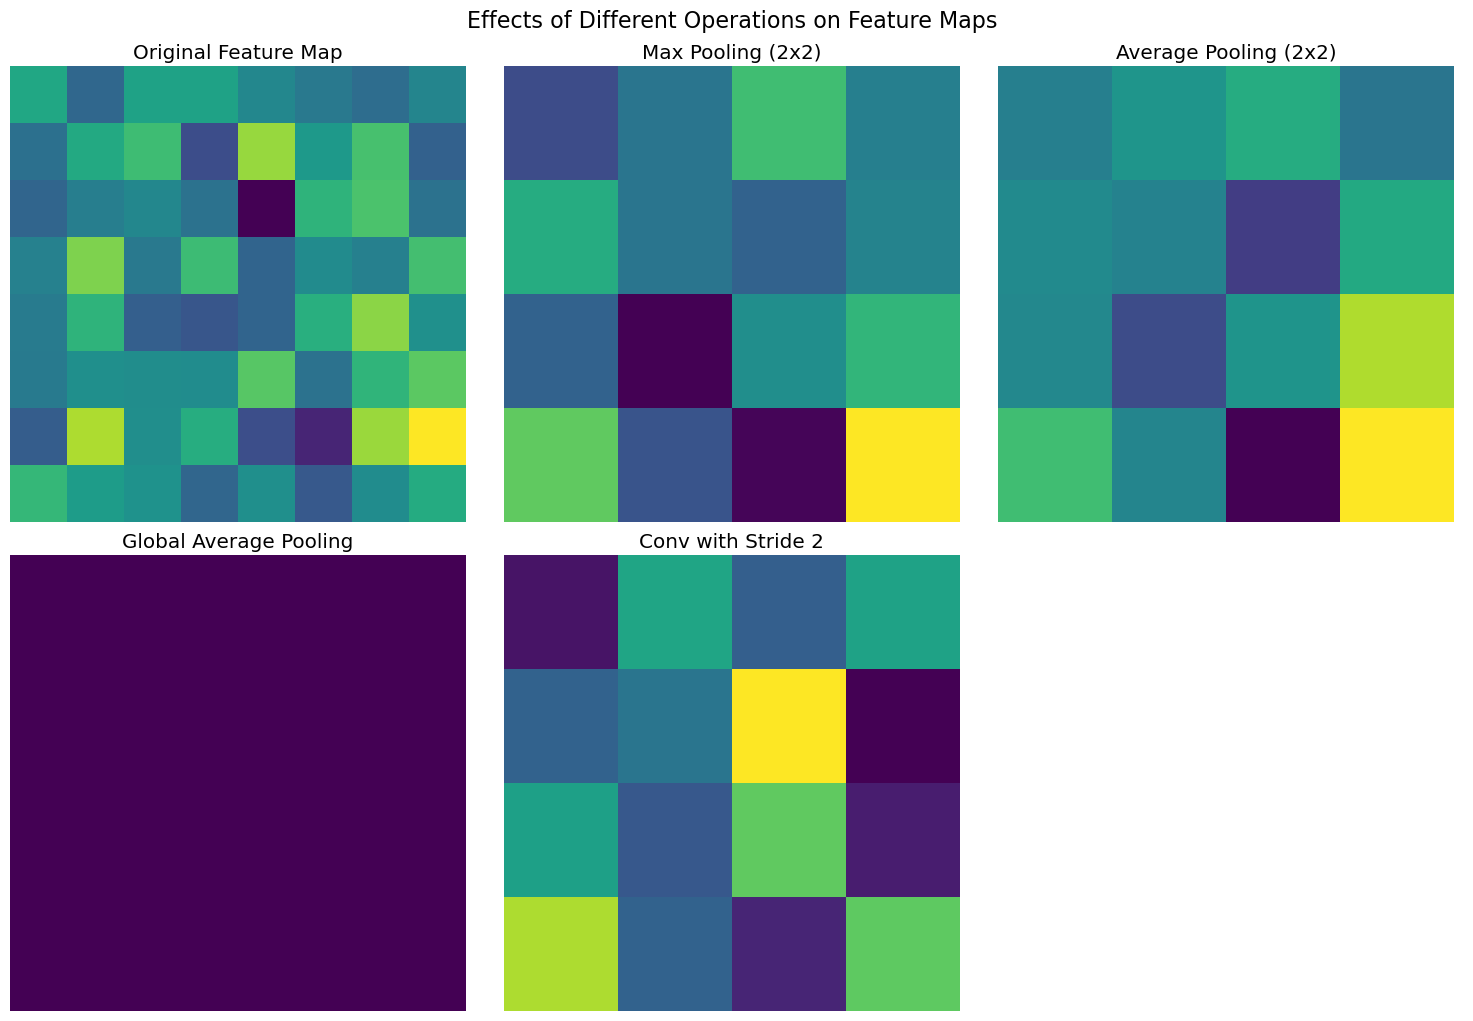

In [7]:
# Exploring Different CNN Layer Types with PyTorch

# Function to calculate output size
def calculate_conv_output_size(input_size, kernel_size, stride=1, padding=0, dilation=1):
    """Calculate output size for convolution."""
    return (input_size + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

def calculate_pool_output_size(input_size, kernel_size, stride=None, padding=0):
    """Calculate output size for pooling."""
    if stride is None:
        stride = kernel_size
    return (input_size + 2 * padding - kernel_size) // stride + 1

# Demonstrate different layer types
print("CNN Layer Types Demonstration")
print("=" * 50)

# Create sample inputs
input_1d = torch.randn(1, 16, 100)  # (batch, channels, length)
input_2d = torch.randn(1, 3, 64, 64)  # (batch, channels, height, width)
input_3d = torch.randn(1, 1, 16, 32, 32)  # (batch, channels, depth, height, width)

print(f"1D Input shape: {input_1d.shape}")
print(f"2D Input shape: {input_2d.shape}")
print(f"3D Input shape: {input_3d.shape}")

# 1D Convolution (for text/sequences)
conv1d = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
output_1d = conv1d(input_1d)
print(f"\n1D Conv Output: {output_1d.shape}")

# 2D Convolution (for images)
conv2d = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
output_2d = conv2d(input_2d)
print(f"2D Conv Output: {output_2d.shape}")

# 3D Convolution (for videos)
conv3d = nn.Conv3d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
output_3d = conv3d(input_3d)
print(f"3D Conv Output: {output_3d.shape}")

# Different pooling operations
print("\n" + "=" * 30)
print("Pooling Operations")
print("=" * 30)

# Max Pooling
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
maxpool_output = maxpool(output_2d)
print(f"MaxPool Output: {maxpool_output.shape}")

# Average Pooling
avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
avgpool_output = avgpool(output_2d)
print(f"AvgPool Output: {avgpool_output.shape}")

# Global Average Pooling
global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
global_output = global_avgpool(output_2d)
print(f"Global AvgPool Output: {global_output.shape}")

# Adaptive Pooling (output to specific size)
adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))
adaptive_output = adaptive_pool(output_2d)
print(f"Adaptive Pool Output: {adaptive_output.shape}")

# Output size calculations
print("\n" + "=" * 30)
print("Output Size Calculations")
print("=" * 30)

input_h, input_w = 64, 64
kernel_size = 3
stride = 1
padding = 1

calculated_size = calculate_conv_output_size(input_h, kernel_size, stride, padding)
print(f"Input: {input_h}x{input_w}")
print(f"Kernel: {kernel_size}, Stride: {stride}, Padding: {padding}")
print(f"Calculated output size: {calculated_size}x{calculated_size}")
print(f"Actual output size: {output_2d.shape[2]}x{output_2d.shape[3]}")

# Demonstrate different padding strategies
print("\n" + "=" * 30)
print("Padding Strategies")
print("=" * 30)

test_input = torch.randn(1, 1, 5, 5)
print(f"Original input shape: {test_input.shape}")

# Valid padding (no padding)
conv_valid = nn.Conv2d(1, 1, kernel_size=3, padding=0)
valid_output = conv_valid(test_input)
print(f"Valid padding output: {valid_output.shape}")

# Same padding (output same size as input)
conv_same = nn.Conv2d(1, 1, kernel_size=3, padding=1)
same_output = conv_same(test_input)
print(f"Same padding output: {same_output.shape}")

# Visualize the effects of different pooling
sample_feature_map = torch.randn(1, 1, 8, 8)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original
axes[0, 0].imshow(sample_feature_map.squeeze().numpy(), cmap='viridis')
axes[0, 0].set_title('Original Feature Map')
axes[0, 0].axis('off')

# Max pooling
max_pooled = F.max_pool2d(sample_feature_map, kernel_size=2)
axes[0, 1].imshow(max_pooled.squeeze().numpy(), cmap='viridis')
axes[0, 1].set_title('Max Pooling (2x2)')
axes[0, 1].axis('off')

# Average pooling
avg_pooled = F.avg_pool2d(sample_feature_map, kernel_size=2)
axes[0, 2].imshow(avg_pooled.squeeze().numpy(), cmap='viridis')
axes[0, 2].set_title('Average Pooling (2x2)')
axes[0, 2].axis('off')

# Global average pooling
global_avg = F.adaptive_avg_pool2d(sample_feature_map, (1, 1))
axes[1, 0].imshow(global_avg.squeeze().numpy().reshape(1, 1), cmap='viridis')
axes[1, 0].set_title('Global Average Pooling')
axes[1, 0].axis('off')

# Stride 2 convolution
conv_stride2 = nn.Conv2d(1, 1, kernel_size=3, stride=2, padding=1)
stride2_output = conv_stride2(sample_feature_map)
axes[1, 1].imshow(stride2_output.squeeze().detach().numpy(), cmap='viridis')
axes[1, 1].set_title('Conv with Stride 2')
axes[1, 1].axis('off')

# Hide last subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.suptitle('Effects of Different Operations on Feature Maps', fontsize=16, y=1.02)
plt.show()

## 5. Implementing CNN from Scratch

### Understanding CNN Backpropagation

For a CNN, we need to compute gradients for:
1. **Filter weights**: Using cross-correlation between input and error gradients
2. **Biases**: Sum of error gradients for each filter
3. **Input gradients**: Full convolution between filters and error gradients

### Key Formulas:

**Filter gradient**: `dW = input ⋆ dL/dOutput`

**Bias gradient**: `db = sum(dL/dOutput)`

**Input gradient**: `dInput = dL/dOutput * rot180(W)`

Where `⋆` denotes cross-correlation and `*` denotes full convolution.

Testing CNN from Scratch
CNN Architecture:
Input shape: (8, 8)
Number of filters: 2
Filter size: 3
Number of classes: 3

Forward pass output: [0.31334541 0.38638803 0.30026656]
Predicted class: 1
Initial loss: 1.1604
Step 0: Loss = 0.9477, Predicted class = 0
Step 20: Loss = 0.0113, Predicted class = 0
Step 40: Loss = 0.0042, Predicted class = 0
Step 60: Loss = 0.0024, Predicted class = 0
Step 80: Loss = 0.0017, Predicted class = 0


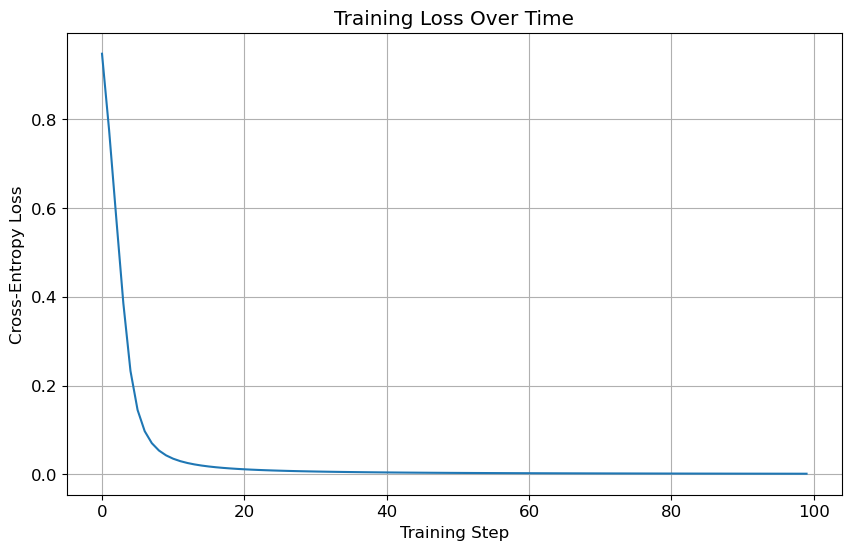


Final loss: 0.0013
✅ CNN from scratch implementation completed!


In [8]:
# Complete CNN Implementation from Scratch

class SimpleCNN:
    """A simple CNN implementation from scratch for educational purposes."""
    
    def __init__(self, input_shape, num_filters, filter_size, num_classes):
        self.input_shape = input_shape  # (height, width)
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.num_classes = num_classes
        
        # Initialize parameters
        self.filters = np.random.randn(num_filters, filter_size, filter_size) * 0.1
        self.filter_bias = np.zeros(num_filters)
        
        # Calculate conv output size
        conv_out_h = input_shape[0] - filter_size + 1
        conv_out_w = input_shape[1] - filter_size + 1
        
        # After pooling (2x2)
        pool_out_h = conv_out_h // 2
        pool_out_w = conv_out_w // 2
        
        # Fully connected layer
        fc_input_size = num_filters * pool_out_h * pool_out_w
        self.fc_weights = np.random.randn(fc_input_size, num_classes) * 0.1
        self.fc_bias = np.zeros(num_classes)
        
        # For storing intermediate values during forward pass
        self.conv_input = None
        self.conv_output = None
        self.pool_output = None
        self.fc_input = None
        
    def relu(self, x):
        """ReLU activation function."""
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        """Derivative of ReLU."""
        return (x > 0).astype(float)
    
    def softmax(self, x):
        """Softmax activation function."""
        exp_x = np.exp(x - np.max(x))  # Numerical stability
        return exp_x / np.sum(exp_x)
    
    def forward(self, x):
        """Forward pass through the network."""
        self.conv_input = x
        
        # Convolutional layer
        conv_out_h = x.shape[0] - self.filter_size + 1
        conv_out_w = x.shape[1] - self.filter_size + 1
        self.conv_output = np.zeros((self.num_filters, conv_out_h, conv_out_w))
        
        for f in range(self.num_filters):
            for i in range(conv_out_h):
                for j in range(conv_out_w):
                    region = x[i:i+self.filter_size, j:j+self.filter_size]
                    self.conv_output[f, i, j] = np.sum(region * self.filters[f]) + self.filter_bias[f]
        
        # ReLU activation
        relu_output = self.relu(self.conv_output)
        
        # Max pooling (2x2)
        pool_h = relu_output.shape[1] // 2
        pool_w = relu_output.shape[2] // 2
        self.pool_output = np.zeros((self.num_filters, pool_h, pool_w))
        
        for f in range(self.num_filters):
            for i in range(pool_h):
                for j in range(pool_w):
                    region = relu_output[f, i*2:(i+1)*2, j*2:(j+1)*2]
                    self.pool_output[f, i, j] = np.max(region)
        
        # Flatten for fully connected layer
        self.fc_input = self.pool_output.flatten()
        
        # Fully connected layer
        fc_output = np.dot(self.fc_input, self.fc_weights) + self.fc_bias
        
        # Softmax
        output = self.softmax(fc_output)
        
        return output
    
    def backward(self, y_true, y_pred, learning_rate=0.01):
        """Backward pass - simplified version."""
        batch_size = 1  # Assuming single sample for simplicity
        
        # Output layer gradient
        dL_dfc_output = y_pred - y_true
        
        # Fully connected layer gradients
        dL_dfc_weights = np.outer(self.fc_input, dL_dfc_output)
        dL_dfc_bias = dL_dfc_output
        dL_dfc_input = np.dot(self.fc_weights, dL_dfc_output)
        
        # Reshape back to pooling output shape
        dL_dpool_output = dL_dfc_input.reshape(self.pool_output.shape)
        
        # Max pooling backward (simplified - assumes 2x2 pooling)
        dL_drelu_output = np.zeros((self.num_filters, 
                                   self.pool_output.shape[1] * 2, 
                                   self.pool_output.shape[2] * 2))
        
        # Propagate gradients through max pooling
        for f in range(self.num_filters):
            for i in range(self.pool_output.shape[1]):
                for j in range(self.pool_output.shape[2]):
                    # Find max position in original 2x2 region
                    region = self.relu(self.conv_output[f, i*2:(i+1)*2, j*2:(j+1)*2])
                    max_idx = np.unravel_index(np.argmax(region), region.shape)
                    dL_drelu_output[f, i*2 + max_idx[0], j*2 + max_idx[1]] = dL_dpool_output[f, i, j]
        
        # ReLU backward
        dL_dconv_output = dL_drelu_output * self.relu_derivative(self.conv_output)
        
        # Convolutional layer gradients
        dL_dfilters = np.zeros_like(self.filters)
        dL_dfilter_bias = np.zeros_like(self.filter_bias)
        
        for f in range(self.num_filters):
            dL_dfilter_bias[f] = np.sum(dL_dconv_output[f])
            
            for i in range(self.conv_output.shape[1]):
                for j in range(self.conv_output.shape[2]):
                    region = self.conv_input[i:i+self.filter_size, j:j+self.filter_size]
                    dL_dfilters[f] += dL_dconv_output[f, i, j] * region
        
        # Update parameters
        self.fc_weights -= learning_rate * dL_dfc_weights
        self.fc_bias -= learning_rate * dL_dfc_bias
        self.filters -= learning_rate * dL_dfilters
        self.filter_bias -= learning_rate * dL_dfilter_bias
    
    def train_step(self, x, y_true, learning_rate=0.01):
        """Single training step."""
        y_pred = self.forward(x)
        self.backward(y_true, y_pred, learning_rate)
        
        # Calculate loss (cross-entropy)
        loss = -np.sum(y_true * np.log(y_pred + 1e-15))
        return loss, y_pred

# Test the CNN implementation
print("Testing CNN from Scratch")
print("=" * 40)

# Create simple dataset
np.random.seed(42)
sample_image = np.random.randn(8, 8)
sample_label = np.array([1, 0, 0])  # One-hot encoded

# Initialize CNN
cnn = SimpleCNN(input_shape=(8, 8), num_filters=2, filter_size=3, num_classes=3)

print(f"CNN Architecture:")
print(f"Input shape: {cnn.input_shape}")
print(f"Number of filters: {cnn.num_filters}")
print(f"Filter size: {cnn.filter_size}")
print(f"Number of classes: {cnn.num_classes}")

# Forward pass
output = cnn.forward(sample_image)
print(f"\nForward pass output: {output}")
print(f"Predicted class: {np.argmax(output)}")

# Training step
initial_loss, _ = cnn.train_step(sample_image, sample_label, learning_rate=0.1)
print(f"Initial loss: {initial_loss:.4f}")

# Train for a few steps
losses = []
for step in range(100):
    loss, pred = cnn.train_step(sample_image, sample_label, learning_rate=0.1)
    losses.append(loss)
    if step % 20 == 0:
        print(f"Step {step}: Loss = {loss:.4f}, Predicted class = {np.argmax(pred)}")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Training Step')
plt.ylabel('Cross-Entropy Loss')
plt.grid(True)
plt.show()

print(f"\nFinal loss: {losses[-1]:.4f}")
print("✅ CNN from scratch implementation completed!")

## 6. PyTorch CNN Implementation

### Professional CNN Design Patterns:

1. **Sequential Model**: Simple stack of layers
2. **Modular Design**: Separate feature extractor and classifier
3. **Custom Modules**: Reusable building blocks
4. **Skip Connections**: For deeper networks

### Best Practices:

- Use `nn.Module` for custom layers
- Initialize weights properly
- Use batch normalization
- Add dropout for regularization
- Implement proper forward method

In [9]:
# Professional CNN Implementation with PyTorch

class BasicCNN(nn.Module):
    """Basic CNN for CIFAR-10 style images with detailed dimension tracking."""
    
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(BasicCNN, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First conv block - Input: (B, 3, 32, 32)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),     # (B, 3, 32, 32) -> (B, 32, 32, 32)
            nn.BatchNorm2d(32),                             # (B, 32, 32, 32) -> (B, 32, 32, 32)
            nn.ReLU(inplace=True),                          # (B, 32, 32, 32) -> (B, 32, 32, 32)
            nn.Conv2d(32, 32, kernel_size=3, padding=1),   # (B, 32, 32, 32) -> (B, 32, 32, 32)
            nn.BatchNorm2d(32),                             # (B, 32, 32, 32) -> (B, 32, 32, 32)
            nn.ReLU(inplace=True),                          # (B, 32, 32, 32) -> (B, 32, 32, 32)
            nn.MaxPool2d(2, 2),                             # (B, 32, 32, 32) -> (B, 32, 16, 16)
            nn.Dropout2d(0.25),                             # (B, 32, 16, 16) -> (B, 32, 16, 16)
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # (B, 32, 16, 16) -> (B, 64, 16, 16)
            nn.BatchNorm2d(64),                             # (B, 64, 16, 16) -> (B, 64, 16, 16)
            nn.ReLU(inplace=True),                          # (B, 64, 16, 16) -> (B, 64, 16, 16)
            nn.Conv2d(64, 64, kernel_size=3, padding=1),   # (B, 64, 16, 16) -> (B, 64, 16, 16)
            nn.BatchNorm2d(64),                             # (B, 64, 16, 16) -> (B, 64, 16, 16)
            nn.ReLU(inplace=True),                          # (B, 64, 16, 16) -> (B, 64, 16, 16)
            nn.MaxPool2d(2, 2),                             # (B, 64, 16, 16) -> (B, 64, 8, 8)
            nn.Dropout2d(0.25),                             # (B, 64, 8, 8) -> (B, 64, 8, 8)
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (B, 64, 8, 8) -> (B, 128, 8, 8)
            nn.BatchNorm2d(128),                            # (B, 128, 8, 8) -> (B, 128, 8, 8)
            nn.ReLU(inplace=True),                          # (B, 128, 8, 8) -> (B, 128, 8, 8)
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # (B, 128, 8, 8) -> (B, 128, 8, 8)
            nn.BatchNorm2d(128),                            # (B, 128, 8, 8) -> (B, 128, 8, 8)
            nn.ReLU(inplace=True),                          # (B, 128, 8, 8) -> (B, 128, 8, 8)
            nn.MaxPool2d(2, 2),                             # (B, 128, 8, 8) -> (B, 128, 4, 4)
            nn.Dropout2d(0.25),                             # (B, 128, 4, 4) -> (B, 128, 4, 4)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),                       # (B, 2048) -> (B, 2048)
            nn.Linear(128 * 4 * 4, 512),                   # (B, 2048) -> (B, 512)
            nn.ReLU(inplace=True),                          # (B, 512) -> (B, 512)
            nn.Dropout(dropout_rate),                       # (B, 512) -> (B, 512)
            nn.Linear(512, num_classes)                     # (B, 512) -> (B, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def forward(self, x):
        # Input: (B, 3, 32, 32) where B = batch_size
        x = self.features(x)        # (B, 3, 32, 32) -> (B, 128, 4, 4)
        x = x.view(x.size(0), -1)   # (B, 128, 4, 4) -> (B, 2048) [Flatten]
        x = self.classifier(x)      # (B, 2048) -> (B, num_classes)
        return x                    # Output: (B, num_classes)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

class ModularCNN(nn.Module):
    """Modular CNN with reusable blocks and dimension tracking."""
    
    def __init__(self, num_classes=10):
        super(ModularCNN, self).__init__()
        
        # Conv blocks with progressive channel increase
        self.conv_block1 = self._make_conv_block(3, 64)      # (B, 3, H, W) -> (B, 64, H//2, W//2)
        self.conv_block2 = self._make_conv_block(64, 128)    # (B, 64, H//2, W//2) -> (B, 128, H//4, W//4)
        self.conv_block3 = self._make_conv_block(128, 256)   # (B, 128, H//4, W//4) -> (B, 256, H//8, W//8)
        
        self.global_pool = nn.AdaptiveAvgPool2d(1)           # (B, 256, H//8, W//8) -> (B, 256, 1, 1)
        self.classifier = nn.Linear(256, num_classes)        # (B, 256) -> (B, num_classes)
        
    def _make_conv_block(self, in_channels, out_channels):
        """Create a convolutional block.
        
        Input: (B, in_channels, H, W)
        Output: (B, out_channels, H//2, W//2)
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # (B, in_ch, H, W) -> (B, out_ch, H, W)
            nn.BatchNorm2d(out_channels),                                    # (B, out_ch, H, W) -> (B, out_ch, H, W)
            nn.ReLU(inplace=True),                                           # (B, out_ch, H, W) -> (B, out_ch, H, W)
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), # (B, out_ch, H, W) -> (B, out_ch, H, W)
            nn.BatchNorm2d(out_channels),                                    # (B, out_ch, H, W) -> (B, out_ch, H, W)
            nn.ReLU(inplace=True),                                           # (B, out_ch, H, W) -> (B, out_ch, H, W)
            nn.MaxPool2d(2, 2)                                               # (B, out_ch, H, W) -> (B, out_ch, H//2, W//2)
        )
    
    def forward(self, x):
        # Input: (B, 3, H, W) - typically (B, 3, 32, 32) for CIFAR-10
        x = self.conv_block1(x)     # (B, 3, H, W) -> (B, 64, H//2, W//2)
        x = self.conv_block2(x)     # (B, 64, H//2, W//2) -> (B, 128, H//4, W//4)
        x = self.conv_block3(x)     # (B, 128, H//4, W//4) -> (B, 256, H//8, W//8)
        x = self.global_pool(x)     # (B, 256, H//8, W//8) -> (B, 256, 1, 1)
        x = x.view(x.size(0), -1)   # (B, 256, 1, 1) -> (B, 256) [Flatten]
        x = self.classifier(x)      # (B, 256) -> (B, num_classes)
        return x                    # Output: (B, num_classes)

class ResidualBlock(nn.Module):
    """Basic residual block with skip connection and dimension tracking."""
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)    # (B, in_ch, H, W) -> (B, out_ch, H//stride, W//stride)
        self.bn1 = nn.BatchNorm2d(out_channels)                       # (B, out_ch, H//stride, W//stride) -> (B, out_ch, H//stride, W//stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                              padding=1, bias=False)                   # (B, out_ch, H//stride, W//stride) -> (B, out_ch, H//stride, W//stride)
        self.bn2 = nn.BatchNorm2d(out_channels)                       # (B, out_ch, H//stride, W//stride) -> (B, out_ch, H//stride, W//stride)
        
        # Skip connection (identity mapping)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            # Adjust dimensions to match main path output
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),                   # (B, in_ch, H, W) -> (B, out_ch, H//stride, W//stride)
                nn.BatchNorm2d(out_channels)                           # (B, out_ch, H//stride, W//stride) -> (B, out_ch, H//stride, W//stride)
            )
    
    def forward(self, x):
        # Input: (B, in_channels, H, W)
        identity = x                                # Store input for skip connection
        
        out = F.relu(self.bn1(self.conv1(x)))      # (B, in_ch, H, W) -> (B, out_ch, H//stride, W//stride)
        out = self.bn2(self.conv2(out))            # (B, out_ch, H//stride, W//stride) -> (B, out_ch, H//stride, W//stride)
        
        # Add skip connection (element-wise addition)
        out += self.skip(identity)                 # (B, out_ch, H//stride, W//stride) + (B, out_ch, H//stride, W//stride)
        out = F.relu(out)                          # (B, out_ch, H//stride, W//stride) -> (B, out_ch, H//stride, W//stride)
        
        return out                                 # Output: (B, out_channels, H//stride, W//stride)

class SimpleResNet(nn.Module):
    """Simple ResNet-like architecture with detailed dimension tracking."""
    
    def __init__(self, num_classes=10):
        super(SimpleResNet, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)  # (B, 3, H, W) -> (B, 64, H, W)
        self.bn1 = nn.BatchNorm2d(64)                                         # (B, 64, H, W) -> (B, 64, H, W)
        
        # Residual layers with progressive downsampling
        self.layer1 = self._make_layer(64, 64, 2, stride=1)     # (B, 64, H, W) -> (B, 64, H, W)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)    # (B, 64, H, W) -> (B, 128, H//2, W//2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)   # (B, 128, H//2, W//2) -> (B, 256, H//4, W//4)
        
        # Global average pooling and classification
        self.global_pool = nn.AdaptiveAvgPool2d(1)              # (B, 256, H//4, W//4) -> (B, 256, 1, 1)
        self.fc = nn.Linear(256, num_classes)                   # (B, 256) -> (B, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        """Create a layer with multiple residual blocks.
        
        First block may have stride > 1 for downsampling.
        Subsequent blocks have stride = 1.
        """
        layers = []
        # First block (may downsample)
        layers.append(ResidualBlock(in_channels, out_channels, stride))  # (B, in_ch, H, W) -> (B, out_ch, H//stride, W//stride)
        # Remaining blocks (no downsampling)
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))     # (B, out_ch, H//stride, W//stride) -> (B, out_ch, H//stride, W//stride)
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Input: (B, 3, H, W) - typically (B, 3, 32, 32) for CIFAR-10
        x = F.relu(self.bn1(self.conv1(x)))    # (B, 3, H, W) -> (B, 64, H, W)
        x = self.layer1(x)                     # (B, 64, H, W) -> (B, 64, H, W)
        x = self.layer2(x)                     # (B, 64, H, W) -> (B, 128, H//2, W//2)
        x = self.layer3(x)                     # (B, 128, H//2, W//2) -> (B, 256, H//4, W//4)
        x = self.global_pool(x)                # (B, 256, H//4, W//4) -> (B, 256, 1, 1)
        x = x.view(x.size(0), -1)              # (B, 256, 1, 1) -> (B, 256) [Flatten]
        x = self.fc(x)                         # (B, 256) -> (B, num_classes)
        return x                               # Output: (B, num_classes)

# Model comparison and analysis
def count_parameters(model):
    """Count trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def analyze_model(model, input_shape=(1, 3, 32, 32)):
    """Analyze model architecture and parameters with detailed dimension tracking."""
    model.eval()
    
    # Count parameters
    total_params = count_parameters(model)
    
    # Calculate model size in MB
    model_size_mb = total_params * 4 / (1024 * 1024)  # Assuming float32
    
    # Test forward pass
    dummy_input = torch.randn(input_shape)
    with torch.no_grad():
        output = model(dummy_input)
    
    # Calculate compression ratio
    input_elements = torch.prod(torch.tensor(input_shape))
    output_elements = torch.prod(torch.tensor(output.shape))
    compression_ratio = input_elements.item() / output_elements.item()
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Total parameters: {total_params:,}")
    print(f"Model size: {model_size_mb:.2f} MB")
    print(f"Input shape: {input_shape}")
    print(f"Output shape: {output.shape}")
    print(f"Input elements: {input_elements:,}")
    print(f"Output elements: {output_elements:,}")
    print(f"Compression ratio: {compression_ratio:.2f}:1")
    print("-" * 60)

def detailed_forward_pass_analysis(model, input_shape=(1, 3, 32, 32)):
    """Perform detailed analysis of forward pass with intermediate shapes."""
    print(f"\nDetailed Forward Pass Analysis for {model.__class__.__name__}")
    print("=" * 70)
    
    model.eval()
    x = torch.randn(input_shape)
    print(f"Input shape: {x.shape}")
    
    # Hook function to capture intermediate outputs
    intermediate_shapes = []
    
    def hook_fn(module, input, output):
        if isinstance(output, torch.Tensor):
            intermediate_shapes.append((module.__class__.__name__, output.shape))
    
    # Register hooks
    hooks = []
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Only leaf modules
            hook = module.register_forward_hook(hook_fn)
            hooks.append(hook)
    
    # Forward pass
    with torch.no_grad():
        output = model(x)
    
    # Print intermediate shapes
    print("\nLayer-wise output shapes:")
    print("-" * 40)
    for i, (layer_name, shape) in enumerate(intermediate_shapes):
        print(f"{i+1:2d}. {layer_name:15s}: {str(shape):25s}")
    
    print(f"\nFinal output shape: {output.shape}")
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return intermediate_shapes

# Test all models
print("CNN Architecture Comparison")
print("=" * 50)

# Create models
basic_cnn = BasicCNN(num_classes=10)
modular_cnn = ModularCNN(num_classes=10)
simple_resnet = SimpleResNet(num_classes=10)

# Analyze each model
models = [basic_cnn, modular_cnn, simple_resnet]
for model in models:
    analyze_model(model)

# Visualize model architecture (for one model)
print("Basic CNN Architecture Details:")
print(basic_cnn)

# Test with different input sizes
print("\nTesting with different input sizes:")
test_sizes = [(1, 3, 32, 32), (1, 3, 64, 64), (1, 3, 224, 224)]

for size in test_sizes:
    try:
        dummy_input = torch.randn(size)
        with torch.no_grad():
            output = modular_cnn(dummy_input)
        print(f"Input {size} -> Output {output.shape}")
    except Exception as e:
        print(f"Input {size} -> Error: {e}")

CNN Architecture Comparison
Model: BasicCNN
Total parameters: 1,342,122
Model size: 5.12 MB
Input shape: (1, 3, 32, 32)
Output shape: torch.Size([1, 10])
Input elements: 3,072
Output elements: 10
Compression ratio: 307.20:1
------------------------------------------------------------
Model: ModularCNN
Total parameters: 1,149,770
Model size: 4.39 MB
Input shape: (1, 3, 32, 32)
Output shape: torch.Size([1, 10])
Input elements: 3,072
Output elements: 10
Compression ratio: 307.20:1
------------------------------------------------------------
Model: SimpleResNet
Total parameters: 2,777,674
Model size: 10.60 MB
Input shape: (1, 3, 32, 32)
Output shape: torch.Size([1, 10])
Input elements: 3,072
Output elements: 10
Compression ratio: 307.20:1
------------------------------------------------------------
Basic CNN Architecture Details:
BasicCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, af

## 7. CNN Architecture Patterns

### Historic CNN Architectures:

1. **LeNet-5 (1998)**
   - First successful CNN
   - Conv → Pool → Conv → Pool → FC → FC
   - 60K parameters

2. **AlexNet (2012)**
   - ImageNet breakthrough
   - Deeper network with ReLU
   - Dropout for regularization
   - 60M parameters

3. **VGG (2014)**
   - Very deep networks (16-19 layers)
   - Small 3×3 filters throughout
   - Simple and uniform architecture

4. **ResNet (2015)**
   - Skip connections solve vanishing gradients
   - Enables very deep networks (50-152 layers)
   - Batch normalization

### Key Design Principles:

- **Depth**: Deeper networks learn more complex features
- **Width**: More filters capture more patterns
- **Skip Connections**: Enable gradient flow in deep networks
- **Batch Normalization**: Stabilizes training

Classic CNN Architectures Comparison
LeNet-5         |     62,006 params | torch.Size([1, 10])
AlexNet         |  3,831,114 params | torch.Size([1, 10])
VGG-11          | 28,144,010 params | torch.Size([1, 10])
Simple ResNet   |  2,777,674 params | torch.Size([1, 10])


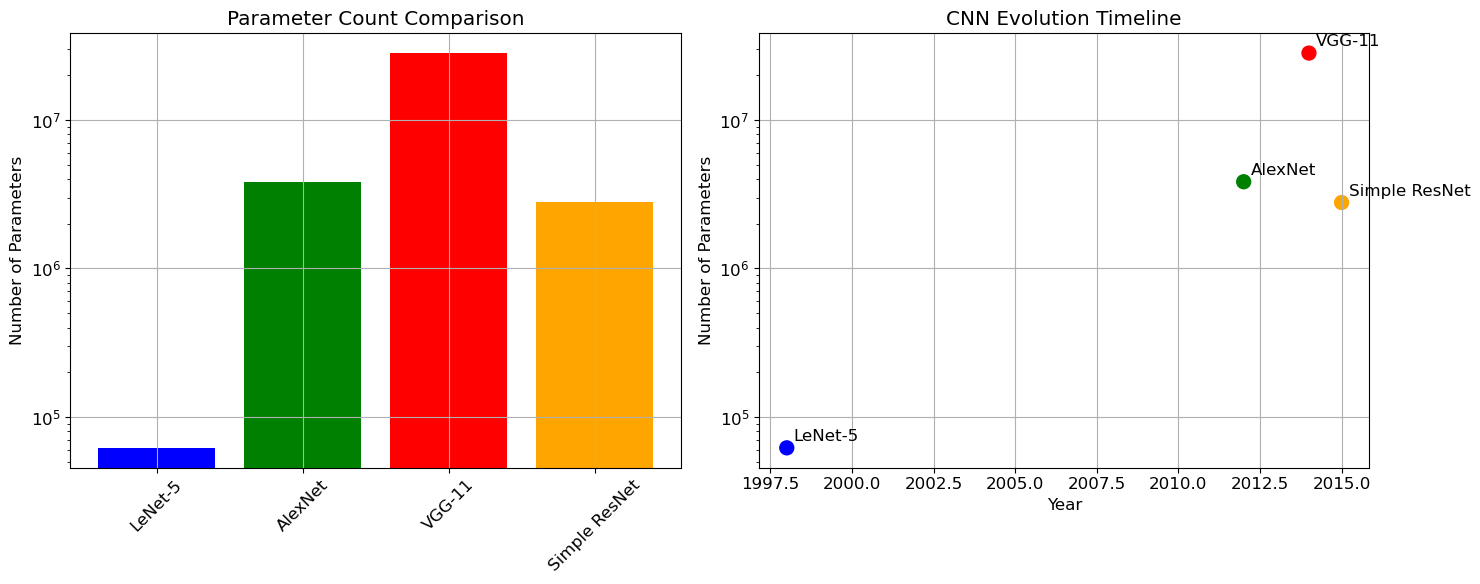


Detailed Architecture Analysis:

LeNet-5 Architecture:
------------------------------
Convolutional layers: 2
Fully connected layers: 3
Total parameters: 62,006

AlexNet Architecture:
------------------------------
Convolutional layers: 5
Fully connected layers: 3
Total parameters: 3,831,114

VGG-11 Architecture:
------------------------------
Convolutional layers: 8
Fully connected layers: 3
Total parameters: 28,144,010

Simple ResNet Architecture:
------------------------------
Convolutional layers: 15
Fully connected layers: 1
Total parameters: 2,777,674

✅ Classic CNN architectures implemented and analyzed!


In [10]:
# Implementing Classic CNN Architectures

class LeNet5(nn.Module):
    """LeNet-5 architecture (modified for CIFAR-10)."""
    
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)  # Modified for RGB input
        self.pool1 = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(2, 2)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
    
    def forward(self, x):
        x = self.pool1(torch.tanh(self.conv1(x)))  # Original used tanh
        x = self.pool2(torch.tanh(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class AlexNet(nn.Module):
    """AlexNet architecture (simplified for CIFAR-10)."""
    
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Smaller kernel for CIFAR
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))  # Adaptive pooling
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class VGGBlock(nn.Module):
    """VGG block with conv layers and pooling."""
    
    def __init__(self, in_channels, out_channels, num_layers):
        super(VGGBlock, self).__init__()
        
        layers = []
        for i in range(num_layers):
            layers.append(nn.Conv2d(in_channels if i == 0 else out_channels, 
                                   out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
        
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.block(x)

class VGG11(nn.Module):
    """VGG-11 architecture."""
    
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()
        
        self.features = nn.Sequential(
            VGGBlock(3, 64, 1),     # 64 channels, 1 conv layer
            VGGBlock(64, 128, 1),   # 128 channels, 1 conv layer
            VGGBlock(128, 256, 2),  # 256 channels, 2 conv layers
            VGGBlock(256, 512, 2),  # 512 channels, 2 conv layers
            VGGBlock(512, 512, 2),  # 512 channels, 2 conv layers
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Architecture comparison
architectures = {
    'LeNet-5': LeNet5(),
    'AlexNet': AlexNet(),
    'VGG-11': VGG11(),
    'Simple ResNet': SimpleResNet()
}

print("Classic CNN Architectures Comparison")
print("=" * 60)

# Compare architectures
comparison_data = []
for name, model in architectures.items():
    params = count_parameters(model)
    
    # Test forward pass
    dummy_input = torch.randn(1, 3, 32, 32)
    with torch.no_grad():
        output = model(dummy_input)
    
    comparison_data.append({
        'Architecture': name,
        'Parameters': f"{params:,}",
        'Output Shape': str(output.shape),
        'Year': {'LeNet-5': 1998, 'AlexNet': 2012, 'VGG-11': 2014, 'Simple ResNet': 2015}[name]
    })
    
    print(f"{name:15} | {params:>10,} params | {str(output.shape):>15}")

# Visualize parameter counts
names = [d['Architecture'] for d in comparison_data]
param_counts = [int(d['Parameters'].replace(',', '')) for d in comparison_data]
years = [d['Year'] for d in comparison_data]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Parameter count comparison
ax1.bar(names, param_counts, color=['blue', 'green', 'red', 'orange'])
ax1.set_ylabel('Number of Parameters')
ax1.set_title('Parameter Count Comparison')
ax1.tick_params(axis='x', rotation=45)
ax1.set_yscale('log')

# Timeline
ax2.scatter(years, param_counts, s=100, c=['blue', 'green', 'red', 'orange'])
for i, name in enumerate(names):
    ax2.annotate(name, (years[i], param_counts[i]), 
                xytext=(5, 5), textcoords='offset points')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Parameters')
ax2.set_title('CNN Evolution Timeline')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

# Detailed architecture analysis
print("\nDetailed Architecture Analysis:")
print("=" * 40)

for name, model in architectures.items():
    print(f"\n{name} Architecture:")
    print("-" * 30)
    
    # Count layers by type
    conv_layers = 0
    fc_layers = 0
    
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            conv_layers += 1
        elif isinstance(module, nn.Linear):
            fc_layers += 1
    
    print(f"Convolutional layers: {conv_layers}")
    print(f"Fully connected layers: {fc_layers}")
    print(f"Total parameters: {count_parameters(model):,}")

print("\n✅ Classic CNN architectures implemented and analyzed!")

## 8. Practical CNN Applications

### Common Applications:

1. **Image Classification**: Assign labels to entire images
2. **Object Detection**: Locate and classify objects in images
3. **Semantic Segmentation**: Classify each pixel
4. **Style Transfer**: Transfer artistic styles
5. **Medical Imaging**: Diagnose diseases from scans

### Key Techniques:

- **Data Augmentation**: Increase dataset diversity
- **Transfer Learning**: Use pre-trained models
- **Ensemble Methods**: Combine multiple models
- **Fine-tuning**: Adapt pre-trained models

Setting up CIFAR-10 dataset...


100%|██████████| 170M/170M [00:34<00:00, 4.94MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
✅ Dataset loaded successfully!
Training samples: 50000
Test samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


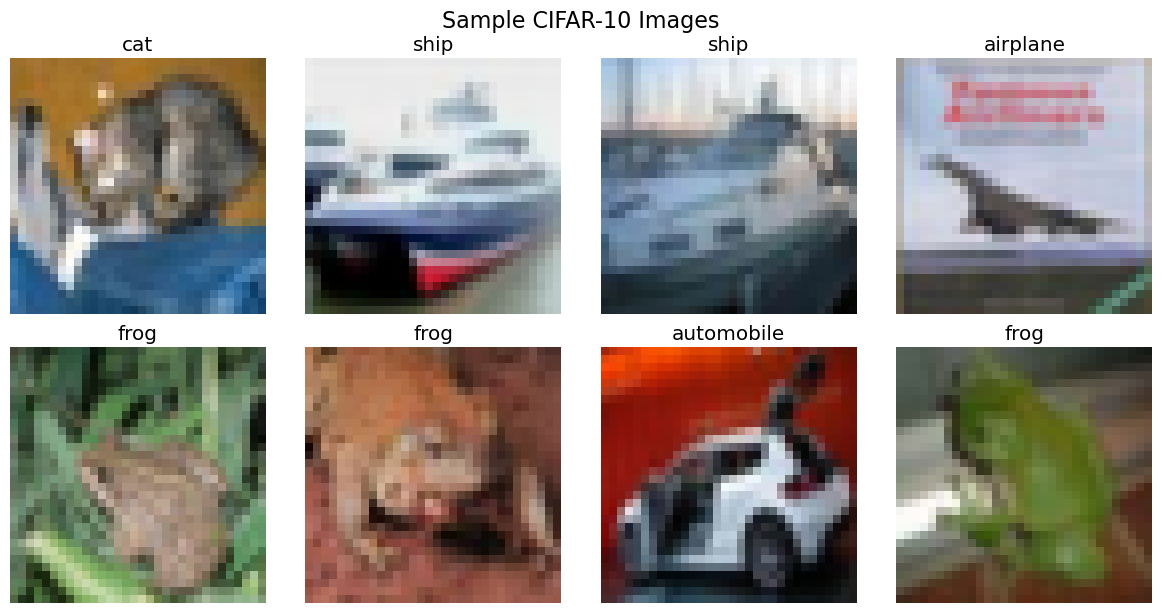


Quick Model Comparison:

Testing Basic CNN...
Training BasicCNN for 2 epochs...
Epoch 1/2:
  Train Loss: 1.7412, Train Acc: 35.29%
  Val Loss: 1.3614, Val Acc: 48.01%
Best validation accuracy: 59.27%


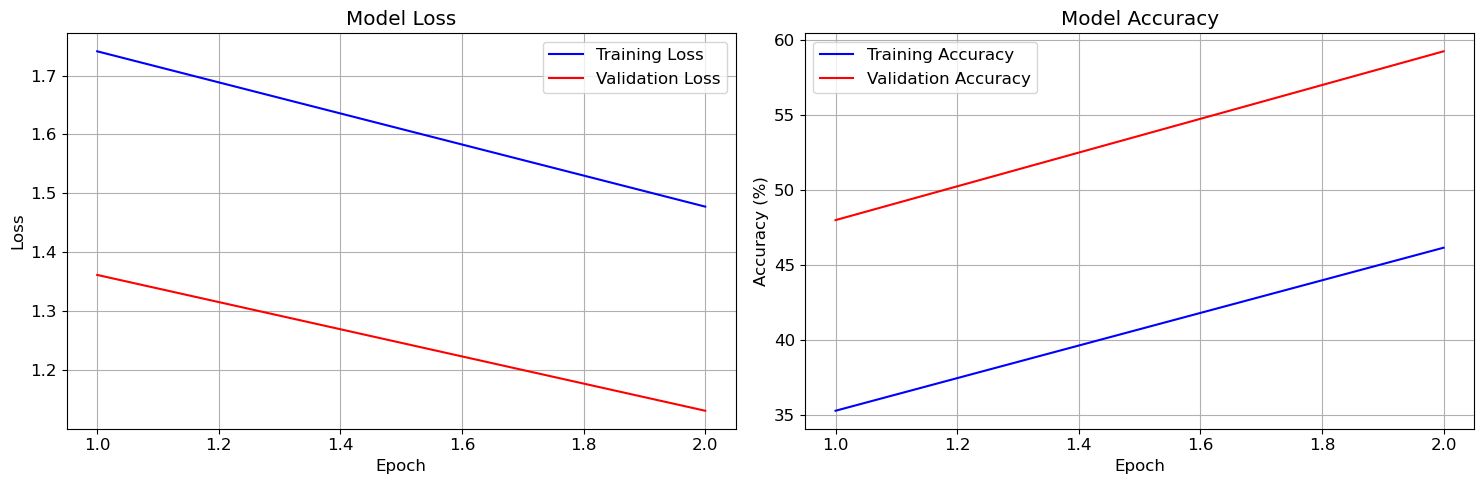


Testing LeNet-5...
Training LeNet5 for 2 epochs...
Epoch 1/2:
  Train Loss: 1.8754, Train Acc: 32.51%
  Val Loss: 1.6653, Val Acc: 40.71%
Best validation accuracy: 45.43%


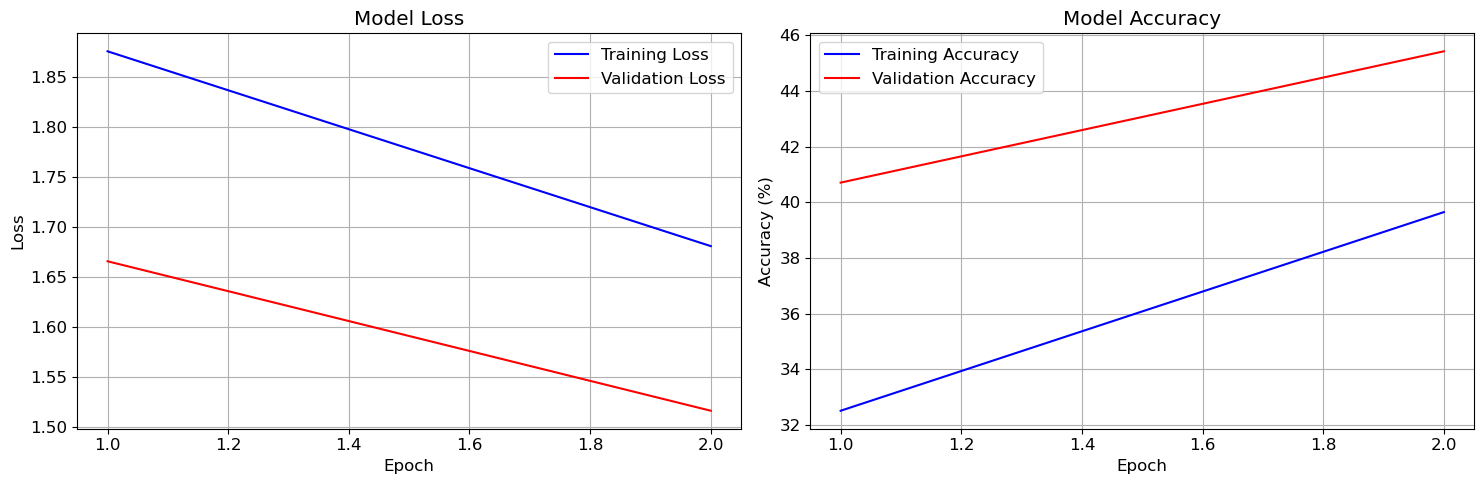


Quick Comparison Results:
Basic CNN: 59.27% best validation accuracy
LeNet-5: 45.43% best validation accuracy

✅ Practical CNN applications demonstrated!


In [11]:
# Practical CNN Applications

# Data augmentation and preprocessing
class CNNDataAugmentation:
    """Comprehensive data augmentation for CNNs."""
    
    def __init__(self):
        self.train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        self.test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    def get_transforms(self):
        return self.train_transform, self.test_transform

# Training utilities
class CNNTrainer:
    """Utility class for training CNNs."""
    
    def __init__(self, model, device, learning_rate=0.001):
        self.model = model.to(device)
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.1)
        
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
    
    def train_epoch(self, train_loader):
        """Train for one epoch."""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        
        return epoch_loss, epoch_acc
    
    def validate(self, val_loader):
        """Validate the model."""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = 100. * correct / total
        
        self.val_losses.append(epoch_loss)
        self.val_accuracies.append(epoch_acc)
        
        return epoch_loss, epoch_acc
    
    def train(self, train_loader, val_loader, epochs=10):
        """Complete training loop."""
        print(f"Training {self.model.__class__.__name__} for {epochs} epochs...")
        
        best_val_acc = 0
        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(train_loader)
            val_loss, val_acc = self.validate(val_loader)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
            
            if epoch % 2 == 0:  # Print every 2 epochs
                print(f'Epoch {epoch+1}/{epochs}:')
                print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
                print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            
            self.scheduler.step()
        
        print(f'Best validation accuracy: {best_val_acc:.2f}%')
        return best_val_acc
    
    def plot_training_history(self):
        """Plot training and validation metrics."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        epochs = range(1, len(self.train_losses) + 1)
        
        # Loss plot
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        ax1.plot(epochs, self.val_losses, 'r-', label='Validation Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy plot
        ax2.plot(epochs, self.train_accuracies, 'b-', label='Training Accuracy')
        ax2.plot(epochs, self.val_accuracies, 'r-', label='Validation Accuracy')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

# Load and prepare CIFAR-10 dataset
def prepare_cifar10_data(batch_size=32):
    """Prepare CIFAR-10 dataset with augmentation."""
    augmentation = CNNDataAugmentation()
    train_transform, test_transform = augmentation.get_transforms()
    
    # Download and load datasets
    trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    testset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    
    # Create data loaders
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, test_loader

# CIFAR-10 class names
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']

print("Setting up CIFAR-10 dataset...")
try:
    train_loader, test_loader = prepare_cifar10_data(batch_size=64)
    print(f"✅ Dataset loaded successfully!")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Test samples: {len(test_loader.dataset)}")
    print(f"Classes: {cifar10_classes}")
    
    # Visualize some samples
    def show_cifar10_samples(loader, num_samples=8):
        """Show sample images from CIFAR-10."""
        dataiter = iter(loader)
        images, labels = next(dataiter)
        
        # Denormalize for visualization
        images = images * 0.5 + 0.5  # Unnormalize
        
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        axes = axes.flatten()
        
        for i in range(num_samples):
            img = images[i].permute(1, 2, 0)  # CHW to HWC
            axes[i].imshow(img)
            axes[i].set_title(f'{cifar10_classes[labels[i]]}')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.suptitle('Sample CIFAR-10 Images', fontsize=16, y=1.02)
        plt.show()
    
    show_cifar10_samples(test_loader)
    
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Will create synthetic data for demonstration...")
    
    # Create synthetic data for demonstration
    def create_synthetic_data(num_samples=1000, batch_size=32):
        X = torch.randn(num_samples, 3, 32, 32)
        y = torch.randint(0, 10, (num_samples,))
        dataset = TensorDataset(X, y)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        return loader
    
    train_loader = create_synthetic_data(1000, 64)
    test_loader = create_synthetic_data(200, 64)
    print("✅ Synthetic dataset created for demonstration")

# Quick model comparison on small dataset
print("\nQuick Model Comparison:")
print("=" * 40)

# Create smaller models for quick testing
small_models = {
    'Basic CNN': BasicCNN(num_classes=10, dropout_rate=0.3),
    'LeNet-5': LeNet5(num_classes=10)
}

# Quick training comparison (2 epochs only)
results = {}
for name, model in small_models.items():
    print(f"\nTesting {name}...")
    trainer = CNNTrainer(model, device, learning_rate=0.001)
    
    # Train for just 2 epochs for demonstration
    best_acc = trainer.train(train_loader, test_loader, epochs=2)
    results[name] = best_acc
    
    # Plot training history
    trainer.plot_training_history()

print("\nQuick Comparison Results:")
for name, acc in results.items():
    print(f"{name}: {acc:.2f}% best validation accuracy")

print("\n✅ Practical CNN applications demonstrated!")

## 9. CNN Visualization and Interpretation

### Visualization Techniques:

1. **Filter Visualization**: Show what filters detect
2. **Feature Maps**: Activations at different layers
3. **Gradient-based Methods**: Saliency maps, GradCAM
4. **Activation Maximization**: Find inputs that maximize neurons

### What CNNs Learn:

- **Layer 1**: Edges, colors, simple patterns
- **Layer 2-3**: Shapes, textures, corners
- **Deeper Layers**: Complex objects, faces, scenes

## 🎯 Exam Summary - Key CNN Concepts

### Essential Formulas:

#### 1. **Output Size Calculation**
```
Output = (Input + 2×Padding - Kernel_size) / Stride + 1
```

#### 2. **Receptive Field**
```
RF_out = (RF_in - 1) × Stride + Kernel_size
```

#### 3. **Parameter Count**
```
Conv Parameters = (Kernel_H × Kernel_W × Input_Channels + 1) × Output_Channels
FC Parameters = Input_Size × Output_Size + Output_Size
```

### Key Differences:

| Concept | Convolution | Cross-correlation |
|---------|-------------|-------------------|
| Operation | Flips kernel | No flipping |
| Deep Learning | Uses cross-correlation | Called "convolution" |
| Mathematical | True convolution | What we actually compute |

### Architecture Timeline:

1. **LeNet-5 (1998)**: First successful CNN
2. **AlexNet (2012)**: ImageNet breakthrough, ReLU, Dropout
3. **VGG (2014)**: Very deep with 3×3 filters
4. **ResNet (2015)**: Skip connections, batch norm

### Exam Tips:

✅ **Remember**: Deep learning "convolution" is actually cross-correlation  
✅ **Padding**: 'same' keeps size, 'valid' reduces size  
✅ **Pooling**: Reduces spatial dimensions, no parameters  
✅ **Skip connections**: Enable very deep networks  
✅ **Batch normalization**: Stabilizes training  

### Common Exam Questions:

1. Calculate output dimensions given input size, kernel, stride, padding
2. Compare convolution vs cross-correlation
3. Explain vanishing gradient problem and solutions
4. Design CNN architecture for specific task
5. Calculate receptive field size
6. Explain different pooling operations

### Practice Problems:

**Q1**: Input 32×32, kernel 5×5, stride 2, padding 1. Output size?  
**A1**: (32 + 2×1 - 5) / 2 + 1 = 16×16

**Q2**: Why use skip connections in deep networks?  
**A2**: Solve vanishing gradients, enable identity mapping

**Q3**: Difference between MaxPool and AvgPool?  
**A3**: Max takes maximum value, Avg takes average value in pooling window